# Install face-alignment package
Environment: Google colab

In [1]:
# Update pyorch to 0.4
#!pip install --upgrade torch

    100% |████████████████████████████████| 484.0MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5c3f8000 @  0x7fe09f1ac1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [2]:
#!git init .
#!git remote add origin https://github.com/1adrianb/face-alignment.git
#!git fetch origin
#!git checkout master

Initialized empty Git repository in /content/.git/
remote: Counting objects: 277, done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 277 (delta 1), reused 3 (delta 0), pack-reused 263
Receiving objects: 100% (277/277), 3.46 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (156/156), done.
From https://github.com/1adrianb/face-alignment
 * [new branch]      master     -> origin/master
 * [new tag]         v1.0.0     -> v1.0.0
Branch master set up to track remote branch master from origin.
Already on 'master'


In [0]:
#%%capture
#!apt update
#!apt install -y cmake

**Install dlib (CUDA enabled or CPU version)**

CUDA enabled dlib

In [ ]:
#%%capture
#!git clone https://github.com/davisking/dlib.git dlib/
#cd dlib/
#!python setup.py install –yes USE_AVX_INSTRUCTIONS –yes DLIB_USE_CUDA

dlib w/o CUDA

In [ ]:
# CPU dlib
#!pip install dlib

In [13]:
#!ls

datalab     examples	    README.md	      setup.cfg  tox.ini
Dockerfile  face_alignment  README.rst	      setup.py
docs	    LICENSE	    requirements.txt  test


In [3]:
#import torch
#torch.__version__

'0.4.0'

# Generate binary masks

```bash
    Inputs:
        Images from ./faceA and ./faceB
    Outputs:
        Eyes binary masks, which are saved to ./binary_masks/faceA_eyes and ./binary_masks/faceB_eyes respectively
```

In [18]:
import face_alignment

In [19]:
import cv2
import numpy as np
from glob import glob
from pathlib import PurePath, Path
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
dir_faceA = "./faceA"
dir_faceB = "./faceB"
dir_bm_faceA_eyes = "./binary_masks/faceA_eyes"
dir_bm_faceB_eyes = "./binary_masks/faceB_eyes"

In [21]:
fns_faceA = glob(f"{dir_faceA}/*.*")
fns_faceB = glob(f"{dir_faceB}/*.*")

In [22]:
#fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, enable_cuda=True, flip_input=False)
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)

In [23]:
# !mkdir -p binary_masks/faceA_eyes
Path(f"binary_masks/faceA_eyes").mkdir(parents=True, exist_ok=True)
# !mkdir -p binary_masks/faceB_eyes
Path(f"binary_masks/faceB_eyes").mkdir(parents=True, exist_ok=True)

In [24]:
fns_face_not_detected = []

for idx, fns in enumerate([fns_faceA, fns_faceB]):
    if idx == 0:
        save_path = dir_bm_faceA_eyes
    elif idx == 1:
        save_path = dir_bm_faceB_eyes     
    
    # create binary mask for each training image
    for fn in fns:
        raw_fn = PurePath(fn).parts[-1]

        x = plt.imread(fn)
        x = cv2.resize(x, (256,256))
        preds = fa.get_landmarks(x)
        
        if preds is not None:
            preds = preds[0]
            mask = np.zeros_like(x)
            
            # Draw right eye binary mask
            pnts_right = [(preds[i,0],preds[i,1]) for i in range(36,42)]
            hull = cv2.convexHull(np.array(pnts_right)).astype(np.int32)
            mask = cv2.drawContours(mask,[hull],0,(255,255,255),-1)

            # Draw left eye binary mask
            pnts_left = [(preds[i,0],preds[i,1]) for i in range(42,48)]
            hull = cv2.convexHull(np.array(pnts_left)).astype(np.int32)
            mask = cv2.drawContours(mask,[hull],0,(255,255,255),-1)

            # Draw mouth binary mask
            #pnts_mouth = [(preds[i,0],preds[i,1]) for i in range(48,60)]
            #hull = cv2.convexHull(np.array(pnts_mouth)).astype(np.int32)
            #mask = cv2.drawContours(mask,[hull],0,(255,255,255),-1)
            
            mask = cv2.dilate(mask, np.ones((13,13), np.uint8), iterations=1)
            mask = cv2.GaussianBlur(mask, (7,7), 0)
            
        else:
            mask = np.zeros_like(x)
            print(f"No faces were detected in image '{fn}''")
            fns_face_not_detected.append(fn)
        
        plt.imsave(fname=f"{save_path}/{raw_fn}", arr=mask, format="jpg")

In [25]:
num_faceA = len(glob(dir_faceA+"/*.*"))
num_faceB = len(glob(dir_faceB+"/*.*"))

print("Nuber of processed images: "+ str(num_faceA + num_faceB))
print("Number of image(s) with no face detected: " + str(len(fns_face_not_detected)))

Nuber of processed images: 740
Number of image(s) with no face detected: 0


# Randomly diaplay a face image and its result binary mask

ValueError: operands could not be broadcast together with shapes (256,256,3) (92,92,3) 

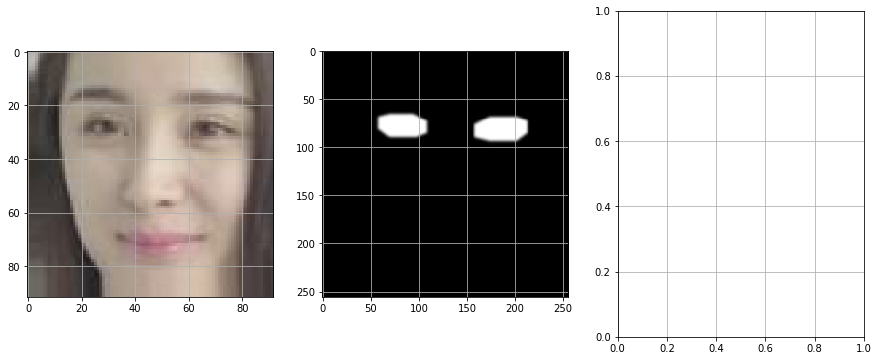

In [26]:
face = np.random.choice(["A","B"])

dir_face = dir_faceA if face == "A" else dir_faceB
fns_face = fns_faceA if face == "A" else fns_faceB
num_face = len(glob(dir_face+"/*.*"))
rand_idx = np.random.randint(num_face)
rand_fn = fns_face[rand_idx]
raw_fn = PurePath(rand_fn).parts[-1]
mask_fn = f"{dir_bm_faceA_eyes}/{raw_fn}" if face == "A" else f"{dir_bm_faceB_eyes}/{raw_fn}"
im = plt.imread(rand_fn)
mask = plt.imread(mask_fn)

if rand_fn in fns_face_not_detected:
    print("========== No faces were detected in this image! ==========")

fig = plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.grid('off')
plt.imshow(im)
plt.subplot(1,3,2)
plt.grid('off')
plt.imshow(mask)
plt.subplot(1,3,3)
plt.grid('off')
plt.imshow((mask/255*im).astype(np.uint8))

#fa.get_landmarks(x)

# Randomly diaplay an image that has no face detected

In [27]:
num_no_face_img = len(fns_face_not_detected)
rand_idx = np.random.randint(num_no_face_img)
x = plt.imread(fns_face_not_detected[rand_idx])
#x = cv2.resize(x, (256,256))

plt.grid('off')
plt.imshow(x)

#fa.get_landmarks(x)

ValueError: Range cannot be empty (low >= high) unless no samples are taken